In [ ]:
import gc
import math
import cv2
import glob
import os, shutil
import numpy as np 
import pandas as pd 
from PIL import Image
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Covid Dataset/newdata

/content/gdrive/My Drive/Covid Dataset/newdata


In [ ]:
data = pd.read_csv('FinData.csv')
arr = data["label"].unique() 
arr

array([1, 2])

In [ ]:
train_image = []
for i in tqdm(range(data.shape[0])):
    img = image.load_img("/content/gdrive/My Drive/Covid Dataset/newdata/" + data['id'][i], target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)
print(type(X))
img

100%|██████████| 657/657 [00:14<00:00, 43.89it/s]


<class 'numpy.ndarray'>


array([[[0.4862745 , 0.4862745 , 0.4862745 ],
        [0.5921569 , 0.5921569 , 0.5921569 ],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.40784314, 0.40784314, 0.40784314],
        [0.45490196, 0.45490196, 0.45490196],
        [0.41960785, 0.41960785, 0.41960785],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.32156864, 0.32156864, 0.32156864],
        [0.40784314, 0.40784314, 0.40784314],
        [0.39215687, 0.39215687, 0.39215687],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
y_init=data['label'].values
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded.shape)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoded)

    y = onehot_encoded
    #print(y)
    return y, label_encoder, onehot_encoder
y, label_encoder, onehot_encoder = prepare_labels(y_init)
y.shape

(657, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
print('y_train shape:', y.shape)

y_train shape: (657, 2)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, y_train, epochs=300, validation_split=0.2,batch_size=32)

Epoch 1/300
14/14 [==============================] - 6s 144ms/step - loss: 0.6231 - accuracy: 0.6384 - val_loss: 0.2920 - val_accuracy: 0.8762
Epoch 2/300
14/14 [==============================] - 1s 53ms/step - loss: 0.2962 - accuracy: 0.8958 - val_loss: 0.1518 - val_accuracy: 0.9524
Epoch 3/300
14/14 [==============================] - 1s 53ms/step - loss: 0.1739 - accuracy: 0.9422 - val_loss: 0.0916 - val_accuracy: 0.9429
Epoch 4/300
14/14 [==============================] - 1s 53ms/step - loss: 0.0886 - accuracy: 0.9779 - val_loss: 0.0972 - val_accuracy: 0.9429
Epoch 5/300
14/14 [==============================] - 1s 53ms/step - loss: 0.0707 - accuracy: 0.9770 - val_loss: 0.0414 - val_accuracy: 1.0000
Epoch 6/300
14/14 [==============================] - 1s 53ms/step - loss: 0.0456 - accuracy: 0.9930 - val_loss: 0.0418 - val_accuracy: 0.9810
Epoch 7/300
14/14 [==============================] - 1s 51ms/step - loss: 0.0282 - accuracy: 0.9993 - val_loss: 0.0327 - val_accuracy: 0.9905
Epoch

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14069603383541107
Test accuracy: 0.9772727489471436


In [ ]:
predictions = model.predict(X_test)

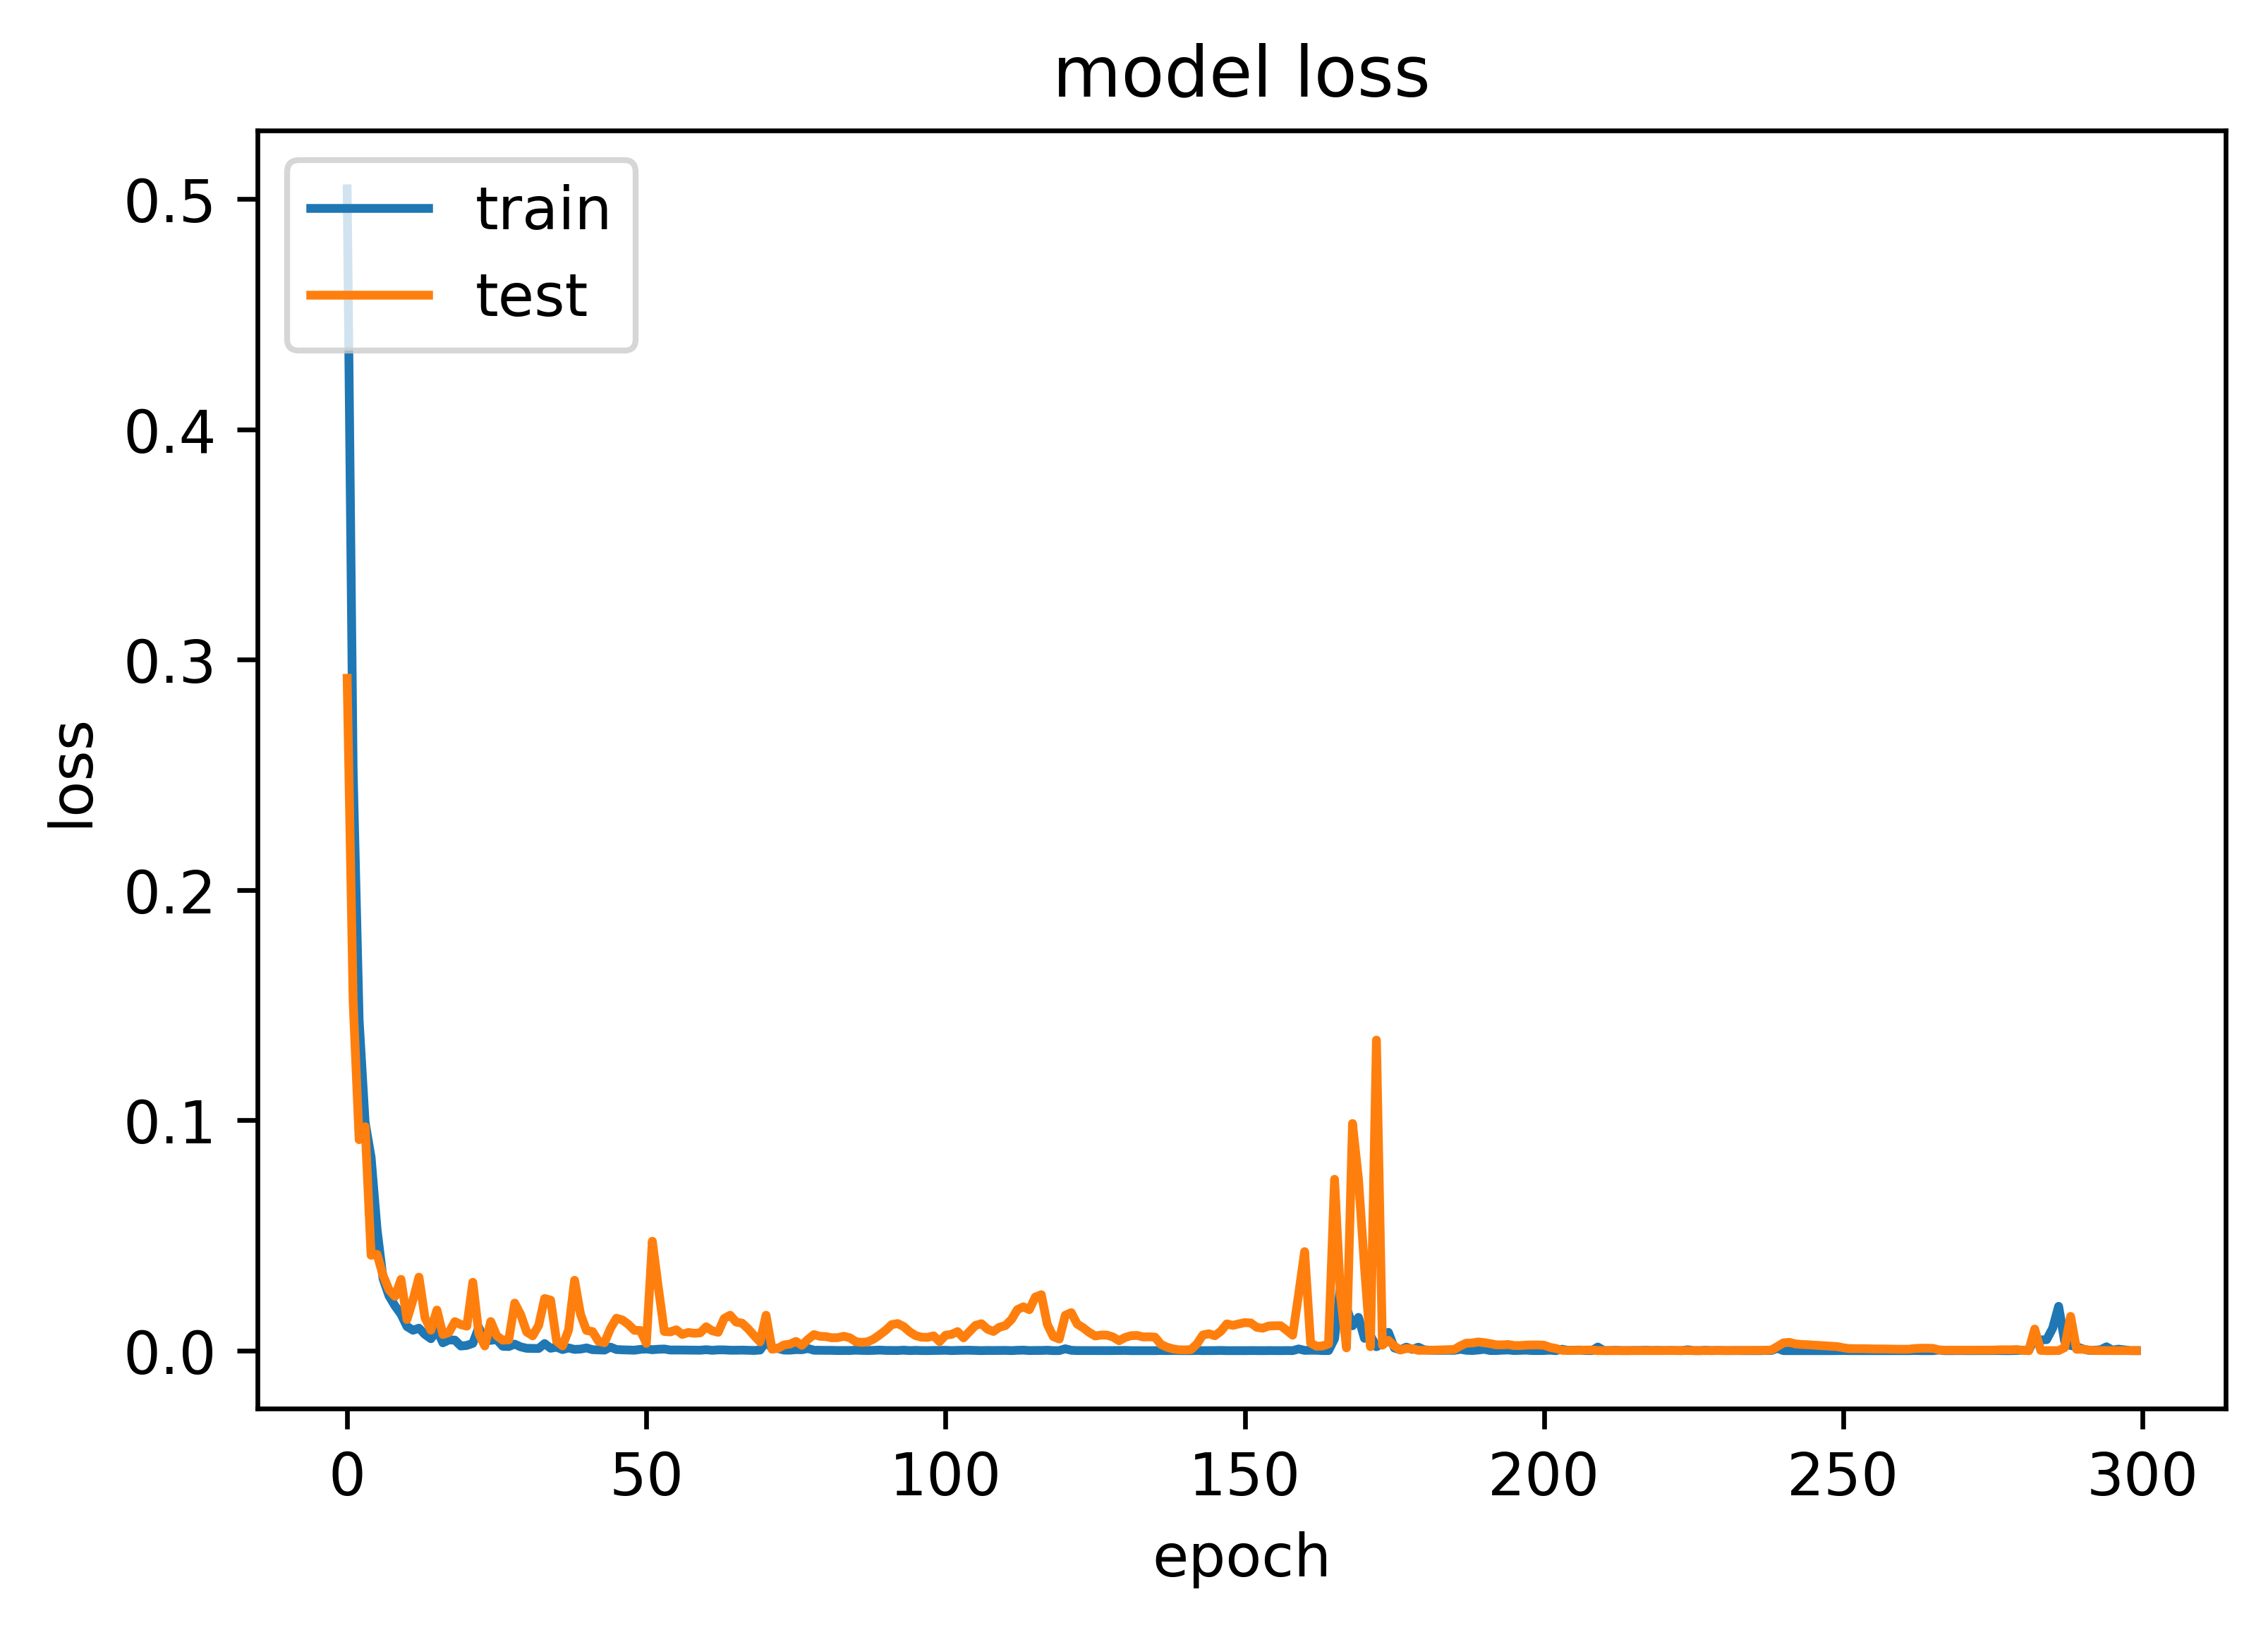

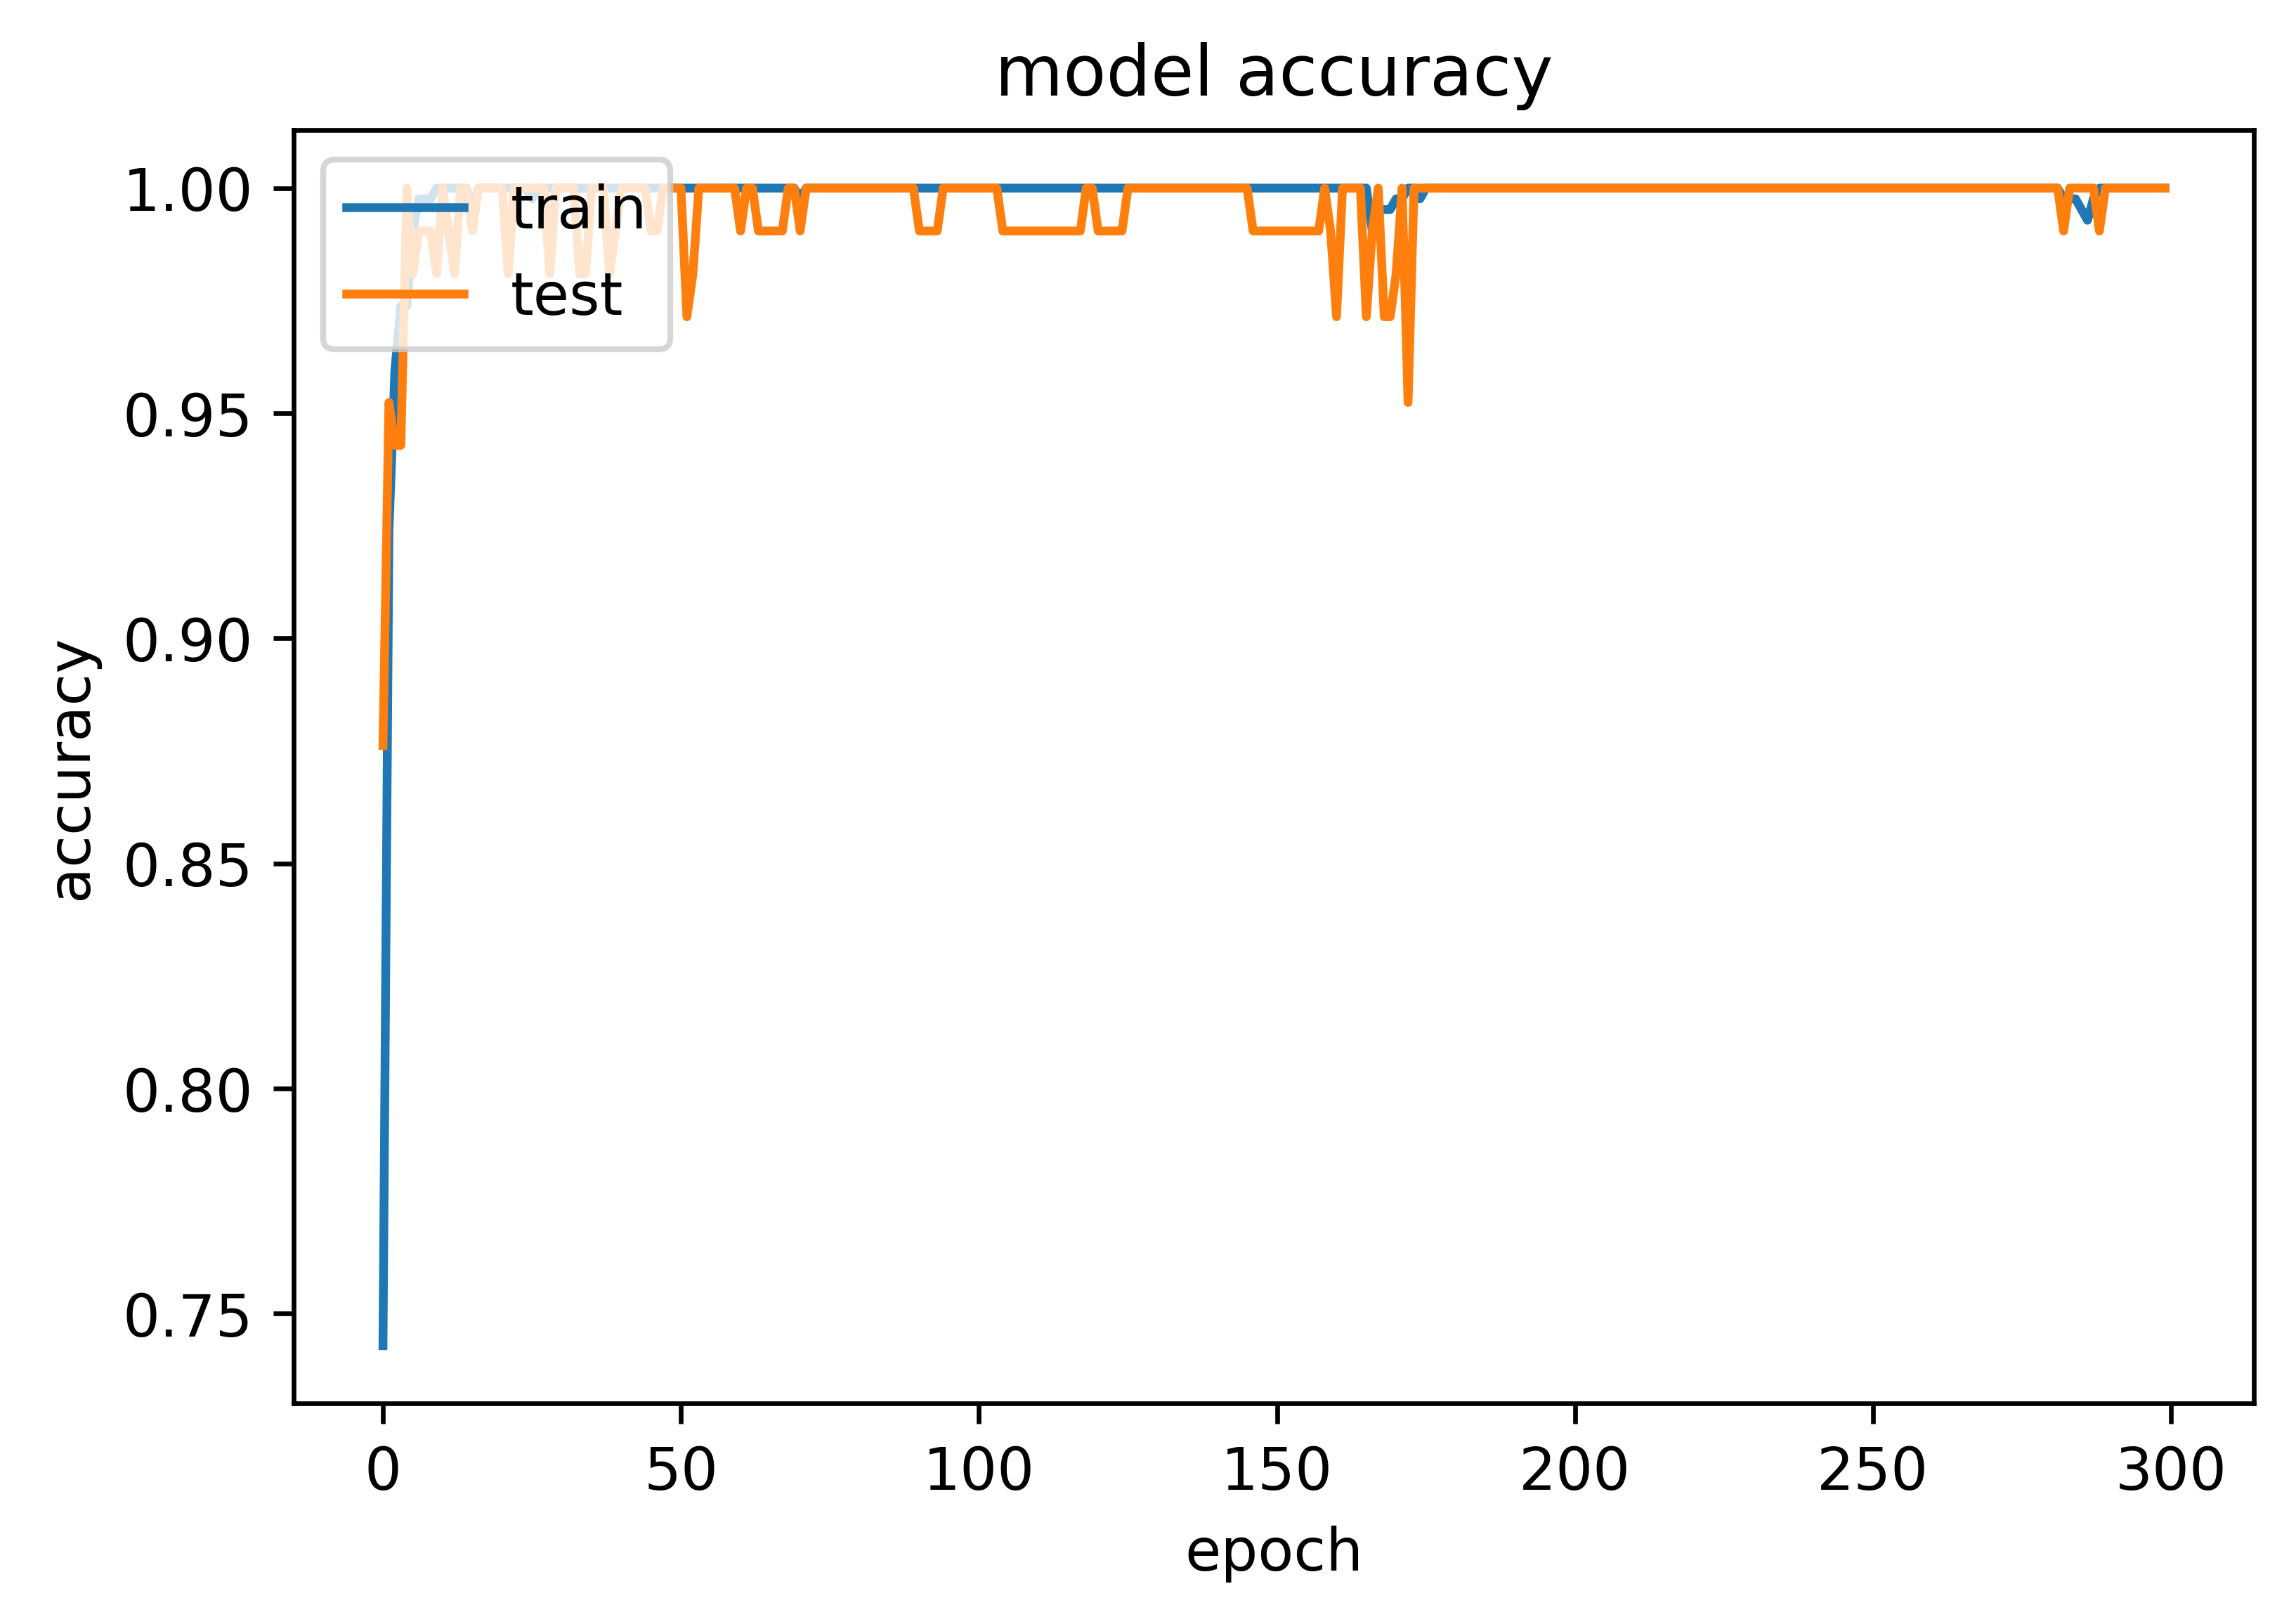

In [ ]:
#summarize the hostory for loss
plt.figure(dpi=600)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.figure(dpi=600)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
inte1 = onehot_encoder.inverse_transform(y_test)
fi1 = label_encoder.inverse_transform(inte1)
Y_pred = model.predict(X_test)
inte = onehot_encoder.inverse_transform(Y_pred)
fi = label_encoder.inverse_transform(inte)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


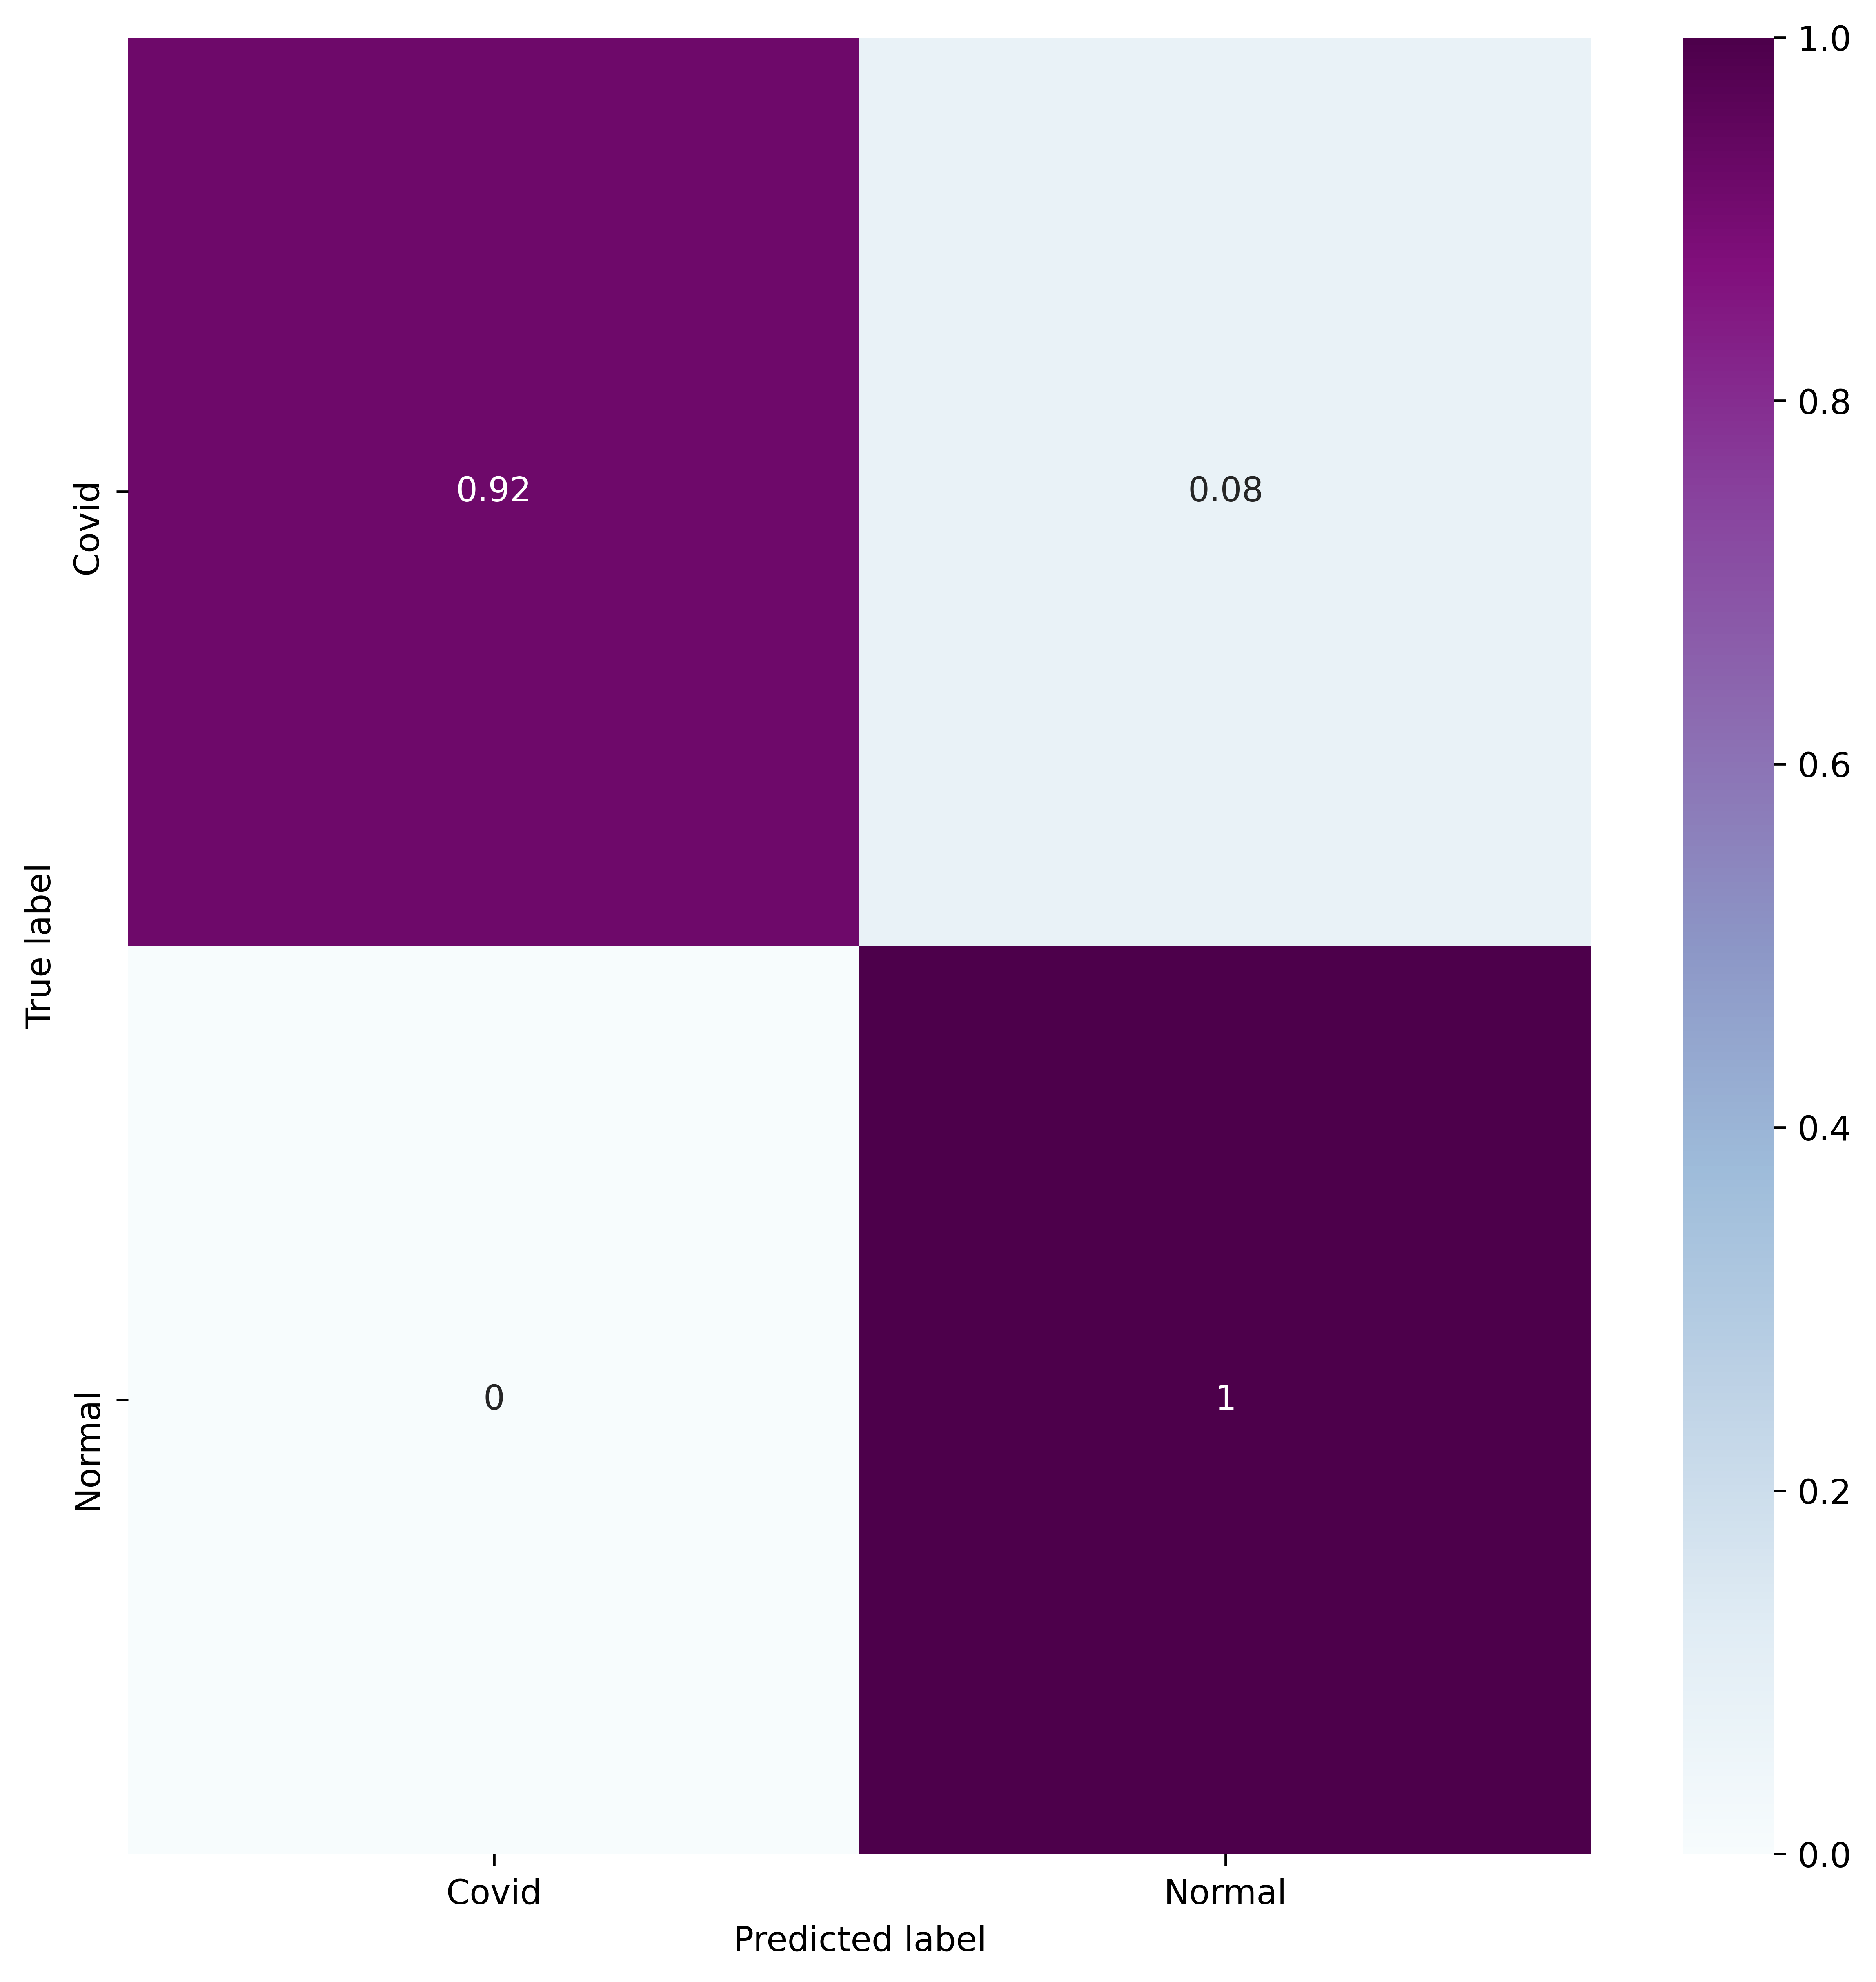

In [ ]:
import seaborn as sns
labels=np.argmax(y_test, axis=1)
pred=np.argmax(predictions, axis=1)
target_names=['Covid', 'Normal']
con_mat = confusion_matrix(labels, pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = target_names, 
                     columns = target_names)
figure = plt.figure(figsize=(8, 8),dpi=600)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.BuPu)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print("Precision Score : ",precision_score(fi1, fi, pos_label=arr[0], average='binary'))
print("Recall Score : ",recall_score(fi1, fi, pos_label=arr[0],average='binary'))
print('Accuracy Score : ' + str(accuracy_score(fi1,fi)))
print('F1 Score : ' + str(f1_score(fi1,fi, pos_label=arr[0],average='binary')))


Precision Score :  1.0
Recall Score :  0.9230769230769231
Accuracy Score : 0.9772727272727273
F1 Score : 0.9600000000000001


In [ ]:
print('Classification Report')
target_names = ['Covid', 'Normal']
print(classification_report(fi1, fi, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Covid       1.00      0.92      0.96        39
      Normal       0.97      1.00      0.98        93

    accuracy                           0.98       132
   macro avg       0.98      0.96      0.97       132
weighted avg       0.98      0.98      0.98       132



In [ ]:
cm1=confusion_matrix(labels,pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9230769230769231
Specificity :  1.0


In [ ]:
print(fi1)
print(len(fi1))
print(fi)
print(len(fi))
tfi1=[]
tfi=[]

for i in fi1:
  if(i==2):
    tfi1.append(0)
  if(i==1):
    tfi1.append(1)

for i in fi:
  if(i==2):
    tfi.append(0)
  if(i==1):
    tfi.append(1)

print(tfi1)
print(len(tfi1))
print(tfi)
print(len(tfi))



[2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1
 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1 2 2 1 2 2
 2 2 2 1 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 1 2 1 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1 2 1 2 2 2 1]
132
[2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1
 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2
 2 2 2 1 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1 2 1 2 2 2 1]
132
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
132
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

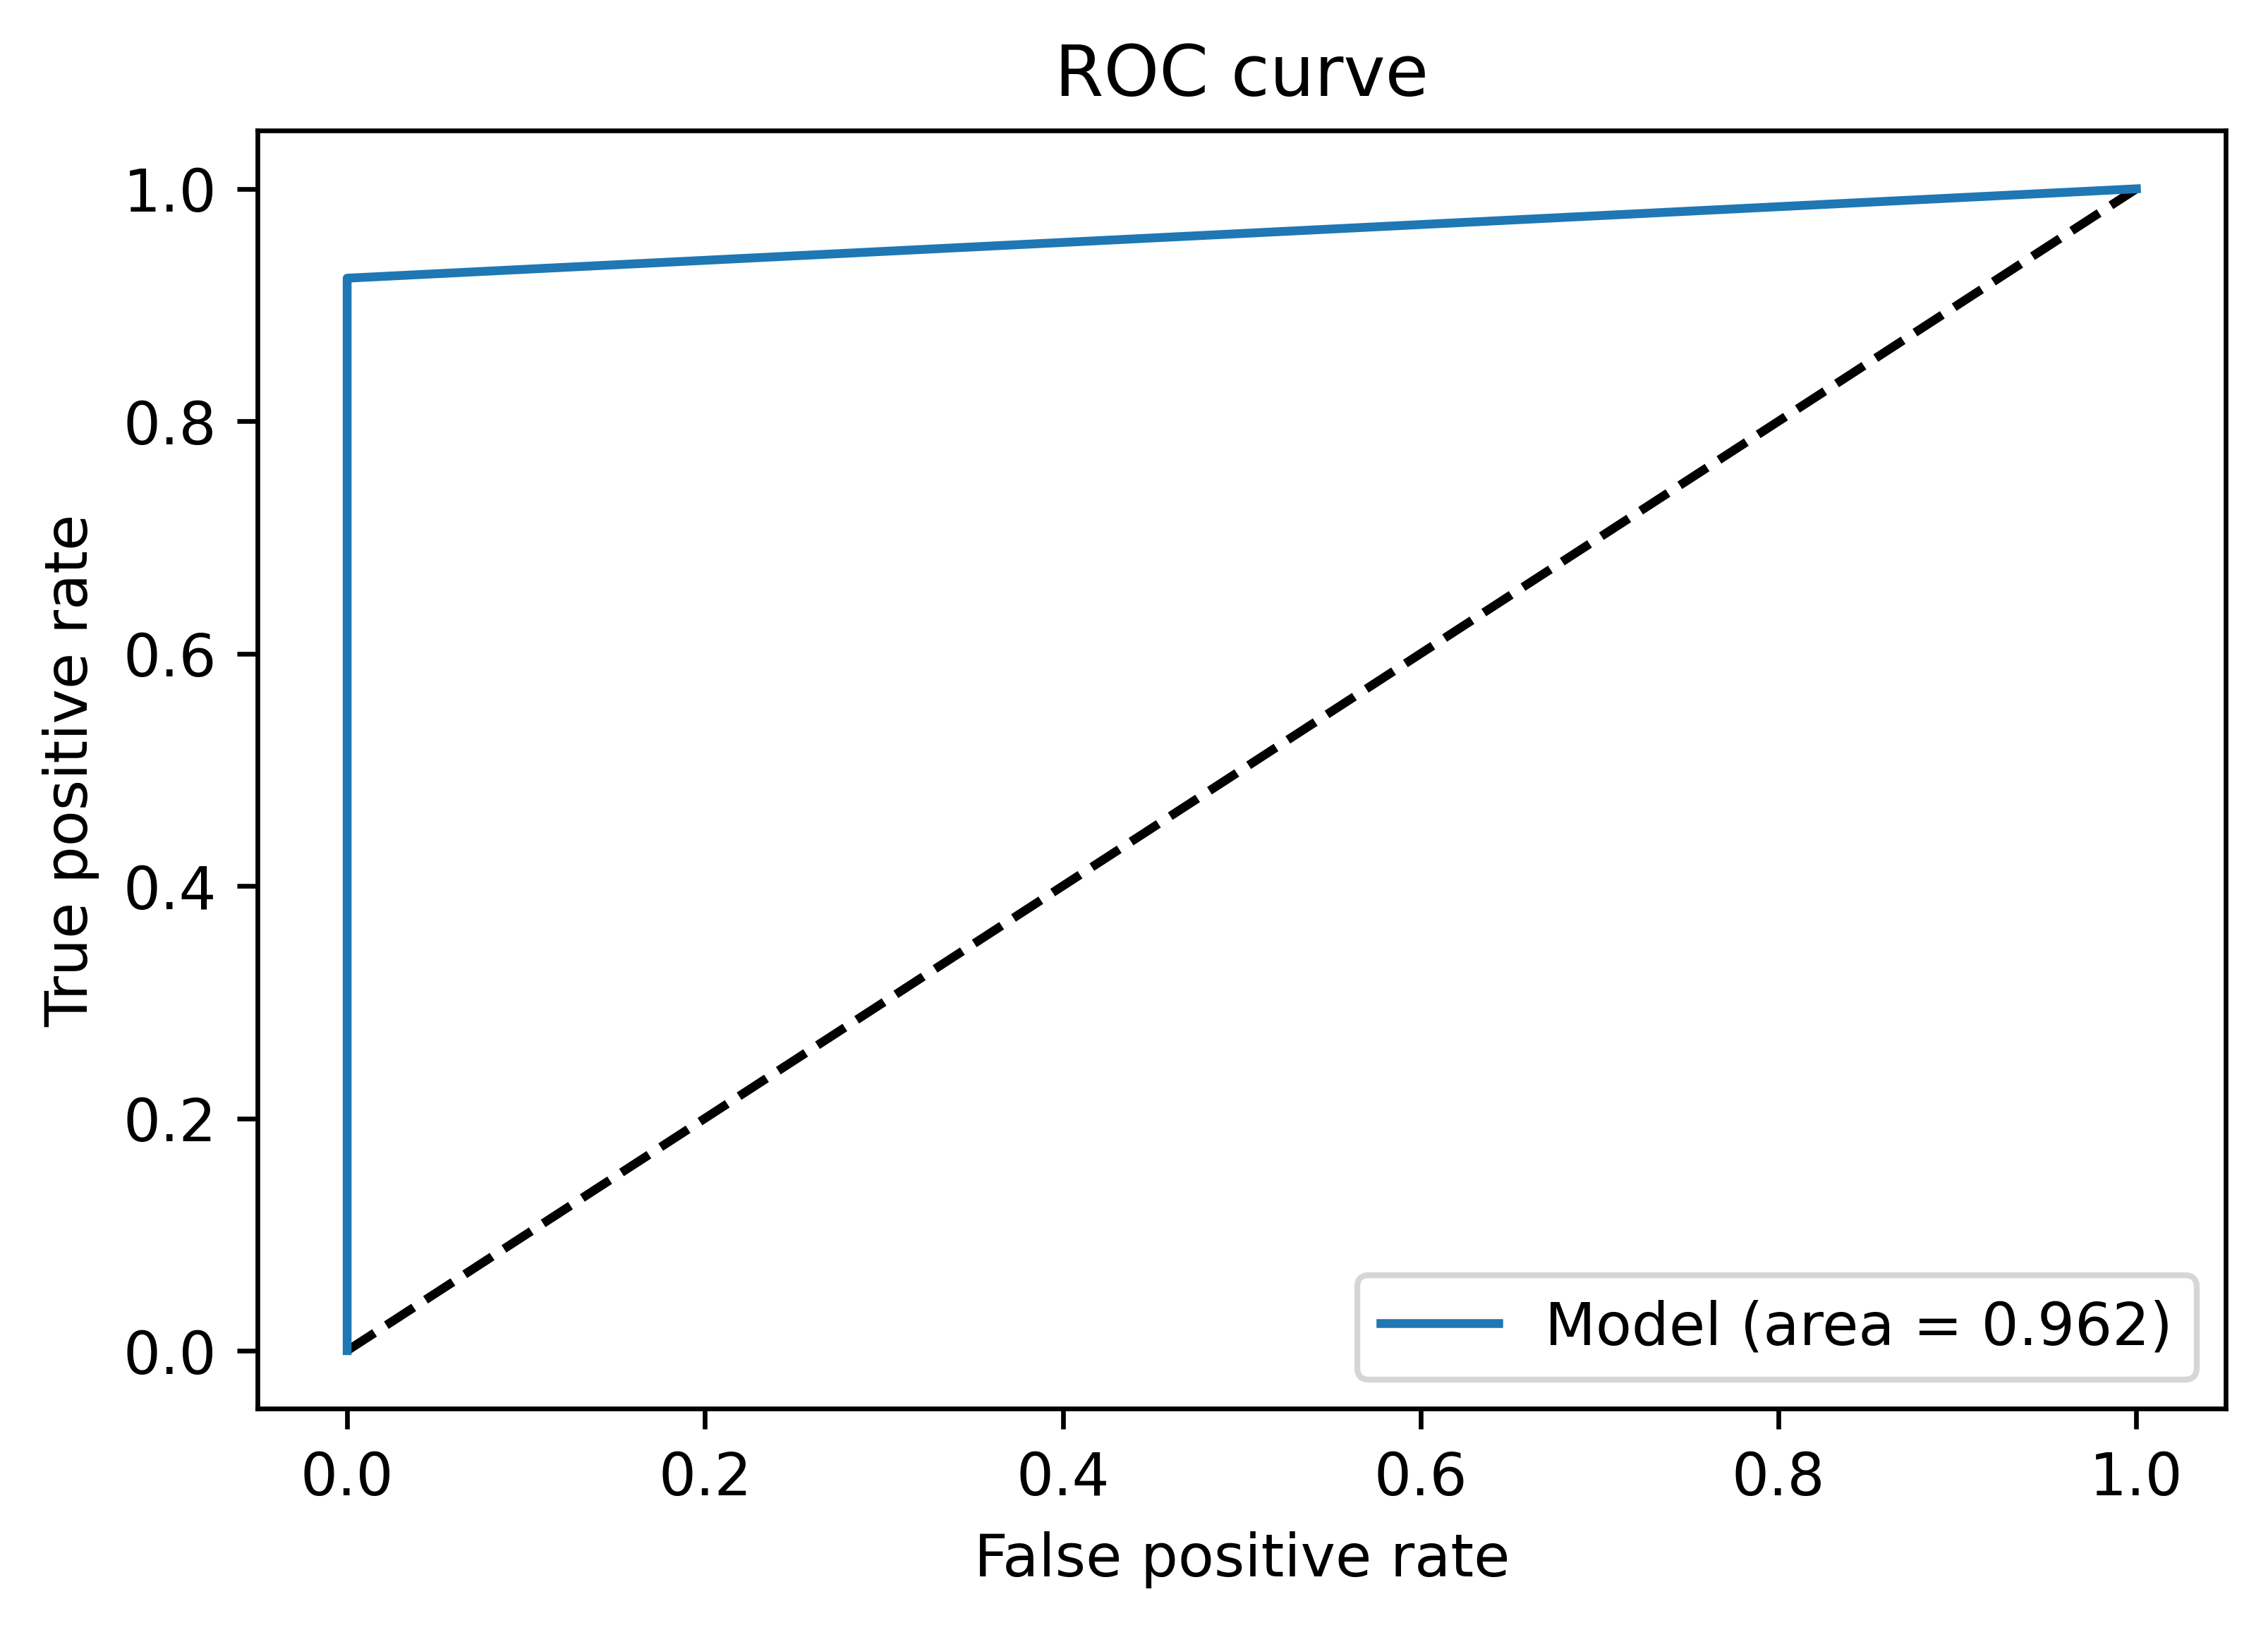

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(tfi1, tfi,pos_label=arr[0])
auc_keras = auc(fpr, tpr)
plt.figure(dpi=600)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(fi1, fi))

0.022727272727272728


In [3]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(fi1, fi, squared=False))

0.15075567228888181
